Kütüphane yüklerken Tensorflow Addons hatası veriyorsa burayı çalıştır. Hata vermiyorsa çalıştırmaya gerek yok.

In [1]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.4 MB/s 


Veri setini kullanmak için öncelikle Dosyalar kısmından ziplenmiş veri setini yükle ardından bu hücredeki kodu çalıştır.

In [2]:
 !unzip Alzheimer_s\ Dataset.zip

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem21.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem210.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem211.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem212.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem213.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem214.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem215.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem216.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem217.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem218.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem219.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem22.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem220.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDe

**Kütüphane Yüklemeleri**

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input # DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D


print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.7.0


**Data Pre-Processing (Veri Ön İşleme)**

In [4]:
base_dir = "Alzheimer_s Dataset/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['VeryMildDemented', 'ModerateDemented', 'MildDemented', 'NonDemented']


In [5]:
WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [6]:
#Performing Image Augmentation to have more data samples
# Daha fazla veri örneğine sahip olmak için Image Augmentation gerçekleştirme

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(preprocessing_function=preprocess_input, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


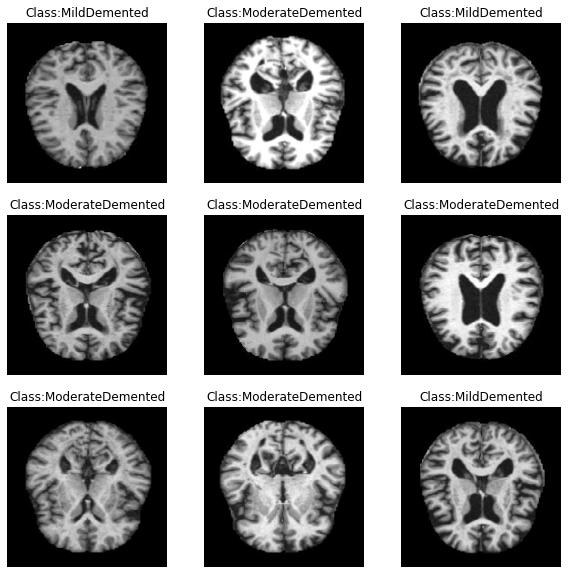

In [ ]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

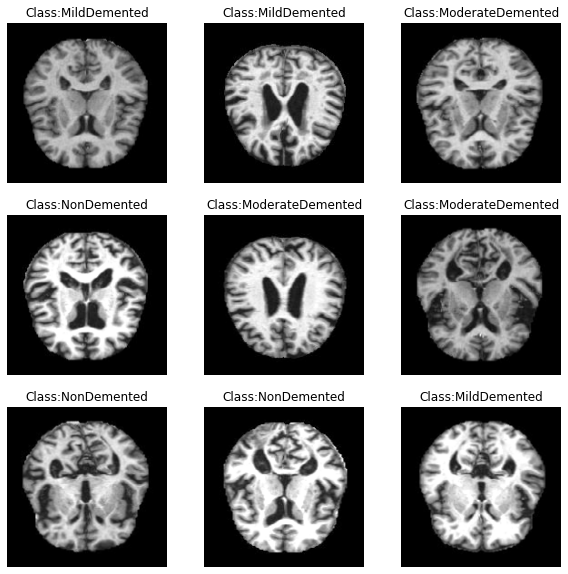

In [ ]:
show_images(train_data_gen)

Yukarıdaki kısımlarda verileri sınıflandırmış. Verilerin görselleştirildiği kısımları çalıştırmaya gerek yok, çalıştırınca 12 GB ram doluyor ve diğer işlemleri yapamıyorsun.

In [7]:
#Retrieving the data from the ImageDataGenerator iterator 
#ImageDataGenerator iterator üzerinden veri alma

train_data, train_labels = train_data_gen.next()

In [8]:
#Getting to know the dimensions of our dataset
#Veri setimizdeki boyutları öğrenme

print(train_data.shape, train_labels.shape)

(6400, 176, 176, 3) (6400, 4)


In [9]:
#Splitting the data into train, test, and validation sets
#Veriyi train, test ve validation olarak ayıralım

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

# VGG16

In [10]:
vgg_model = VGG16(input_shape=(176, 176, 3), include_top=False, weights="imagenet")

58900480/58889256 [==============================] - 0s 0us/step


In [11]:
for layer in vgg_model.layers:
    layer.trainable=False

In [12]:
custom_vgg_model = Sequential([
        vgg_model,
        Dropout(0.5),
        Flatten(),
        BatchNormalization(),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(4, activation='softmax')        
    ], name = "vgg_cnn_model")

In [16]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)

In [17]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           tfa.metrics.F1Score(num_classes=4)]

CALLBACKS = [my_callback, rop_callback]
    
custom_vgg_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

custom_vgg_model.summary()

Model: "vgg_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 5, 5, 512)         0         
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 batch_normalization (BatchN  (None, 12800)            51200     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1024)              13108224  
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                     

**Training & Testing the Model (Modeli Eğitelim ve Test Edelim)**




In [18]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 100

history = custom_vgg_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/100
128/128 [==============================] - 32s 222ms/step - loss: 0.3958 - acc: 0.8567 - auc: 0.9712 - f1_score: 0.8385 - val_loss: 1.5997 - val_acc: 0.7393 - val_auc: 0.9001 - val_f1_score: 0.7596 - lr: 0.0010
Epoch 2/100
128/128 [==============================] - 28s 218ms/step - loss: 0.3542 - acc: 0.8674 - auc: 0.9770 - f1_score: 0.8627 - val_loss: 1.6358 - val_acc: 0.7061 - val_auc: 0.9011 - val_f1_score: 0.6905 - lr: 0.0010
Epoch 3/100
128/128 [==============================] - 28s 219ms/step - loss: 0.3595 - acc: 0.8625 - auc: 0.9770 - f1_score: 0.8703 - val_loss: 1.7363 - val_acc: 0.7246 - val_auc: 0.9118 - val_f1_score: 0.7423 - lr: 0.0010
Epoch 4/100
128/128 [==============================] - 28s 219ms/step - loss: 0.3383 - acc: 0.8779 - auc: 0.9789 - f1_score: 0.8643 - val_loss: 1.4708 - val_acc: 0.7559 - val_auc: 0.9148 - val_f1_score: 0.7722 - lr: 0.0010
Epoch 5/100
128/128 [==============================] - 28s 219ms/step - loss: 0.3301 - acc: 0.8755 - auc: 0.

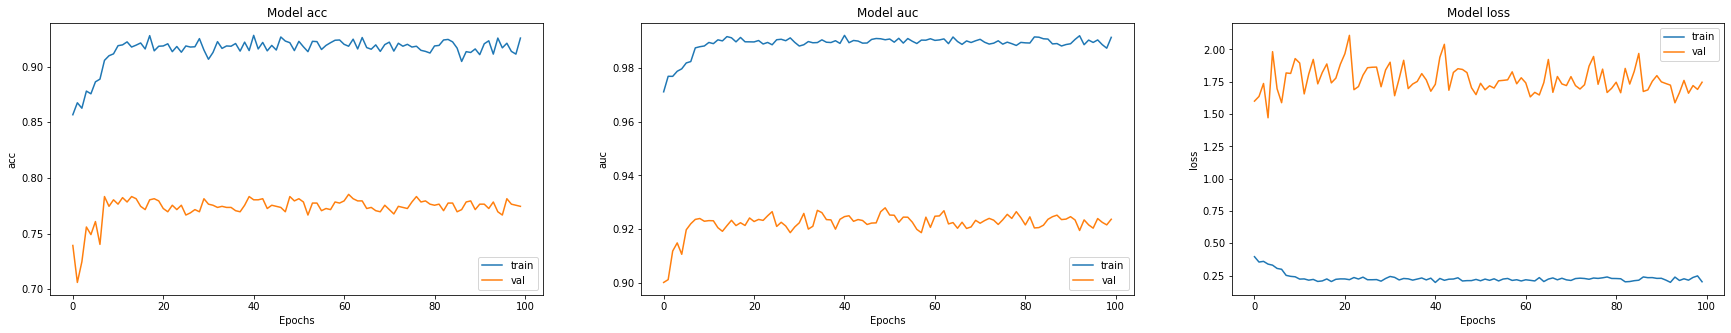

In [19]:
#Plotting the trend of the metrics during training
#Eğitim sırasındaki metriklerin (accuracy, auc, loss) eğilimlerini çizme

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [20]:
#Evaluating the model on the data

#train_scores = model.evaluate(train_data, train_labels)
#val_scores = model.evaluate(val_data, val_labels)
test_scores = custom_vgg_model.evaluate(test_data, test_labels)

#print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
#print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

40/40 [==============================] - 7s 163ms/step - loss: 1.5629 - acc: 0.7945 - auc: 0.9357 - f1_score: 0.8171
Testing Accuracy: 79.45%


In [21]:
#Predicting the test data

pred_labels = custom_vgg_model.predict(test_data)

In [22]:
#Saving the model for future use

custom_vgg_model_dir = work_dir + "alzheimer_vgg_model"
custom_vgg_model.save(custom_vgg_model_dir, save_format='h5')
os.listdir(work_dir)

['VeryMildDemented',
 'ModerateDemented',
 'MildDemented',
 'alzheimer_vgg_model',
 'NonDemented']

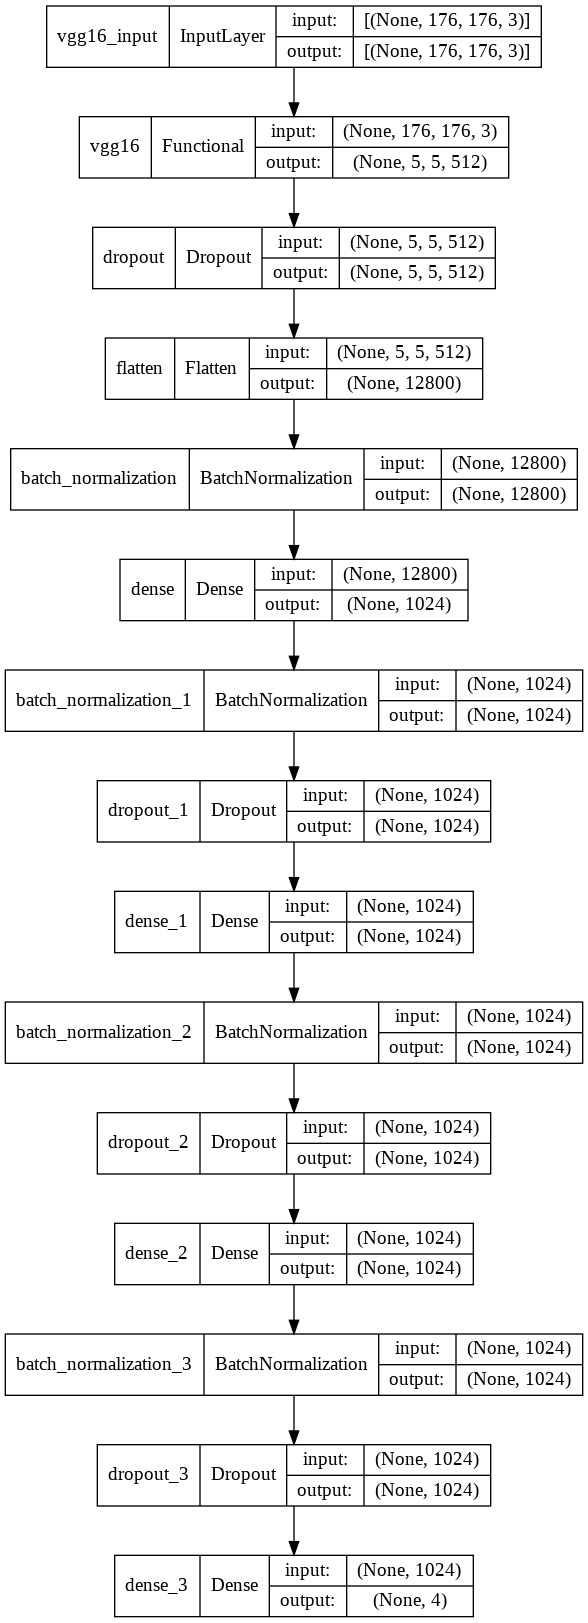

In [23]:
pretrained_model = tf.keras.models.load_model(custom_vgg_model_dir)

#Check its architecture
plot_model(pretrained_model, to_file=work_dir + "model_plot.png", show_shapes=True, show_layer_names=True)